# TensorFlow 教程 #05
# 集成学习

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)/[GitHub中文](https://github.com/Hvass-Labs/TensorFlow-Tutorials-Chinese)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

中文翻译 [thrillerist](https://zhuanlan.zhihu.com/insight-pixel)修订[ZhouGeorge](https://github.com/ZhouGeorge) 

## 警告

**这份教程使用的TensorFlow的版本不是v1.9，由于PrettyTensor构筑API不再被Google开发者更新和支持。建议你用_Kears API_代替，用它训练或加载多个模型去创建一个集成模型更容易，教程 #10 有关于如何使用Keras加载和使用预训练模型。**


## 简介

这篇教程介绍了卷积神经网络的集成（ensemble）。我们使用多个神经网络，然后取它们输出的平均，而不是只用一个。

最终也是在MINIST数据集上识别手写数字。ensemble稍微地提升了测试集上的分类准确率，但差异很小，也可能是随机出现的。此外，ensemble误分类的一些图像在单独网络上却是正确分类的。

本文基于上一篇教程，你需要了解基本的TensorFlow和附加包Pretty Tensor。其中大量代码和文字与之前教程相似，如果你已经看过就可以快速地浏览本文。

## 流程图

下面的图表直接显示了之后实现的卷积神经网络中数据的传递。网络有两个卷积层和两个全连接层，最后一层是用来给输入图像分类的。关于网络和卷积的更多细节描述见教程 #02 。

本教程实现了5个这样的神经网络的集成，每个网络的结构相同但权重以及其他变量不同。

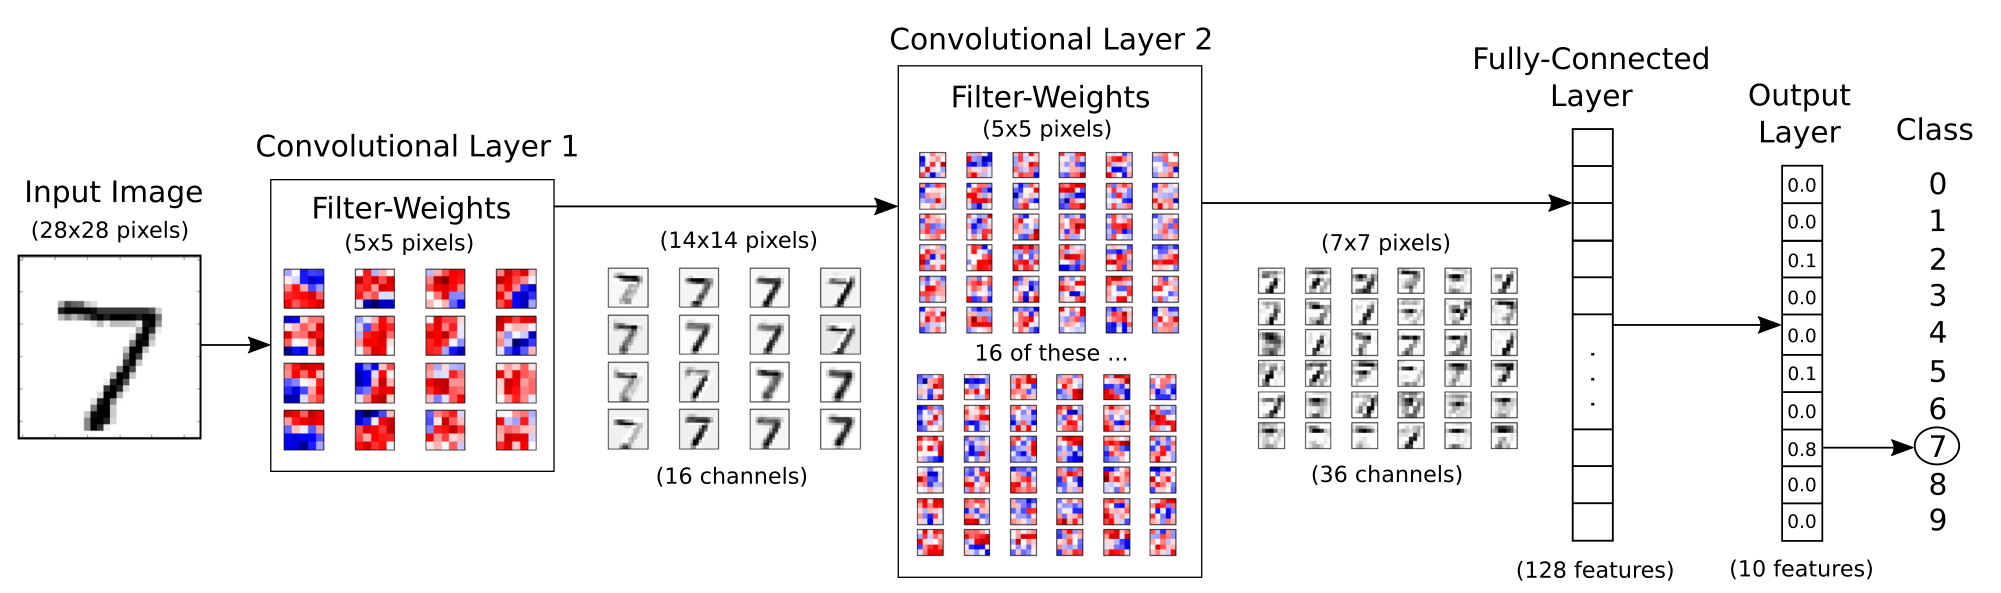

In [1]:
from IPython.display import Image
Image('images/02_network_flowchart.png')

## 导入

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

使用Python3.5.2（Anaconda）开发，TensorFlow版本是：

In [3]:
tf.__version__

'1.6.0'

PrettyTensor 版本:

In [4]:
pt.__version__

'0.7.4'

## 载入数据

MNIST数据集大约12MB，如果没在给定路径中找到就会自动下载。

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


现在已经载入了MNIST数据集，它由70,000张图像和对应的标签（比如图像的类别）组成。数据集分成三份互相独立的子集，但后面我们会生成随机的训练集。

In [6]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


### 类别数字

类型标签使用One-Hot编码，这意外每个标签是长为10的向量，除了一个元素之外，其他的都为零。这个元素的索引就是类别的数字，即相应图片中画的数字。我们也需要测试集和验证集的整形类别数字，在这里计算。

In [7]:
data.test.cls = np.argmax(data.test.labels, axis=1)
data.validation.cls = np.argmax(data.validation.labels, axis=1)

### 创建随机训练集的帮助函数

我们将会在随机选择的训练集上训练5个不同的神经网络。首先，将原始训练集和验证集合并到大的一个数组中。图像和标签都要进行此操作。

In [8]:
combined_images = np.concatenate([data.train.images, data.validation.images], axis=0)
combined_labels = np.concatenate([data.train.labels, data.validation.labels], axis=0)

检查合并后的数组大小是否正确。

In [9]:
print(combined_images.shape)
print(combined_labels.shape)

(60000, 784)
(60000, 10)


合并数据集的大小。

In [10]:
combined_size = len(combined_images)
combined_size

60000

定义每个神经网络使用的训练集的大小。你可以试着改变大小。

In [11]:
train_size = int(0.8 * combined_size)
train_size

48000

在训练时并没有使用验证集，但它的大小如下。

In [12]:
validation_size = combined_size - train_size
validation_size

12000

帮助函数将合并数组集划分成随机的训练集和验证集。

In [13]:
def random_training_set():
    # Create a randomized index into the full / combined training-set.
    idx = np.random.permutation(combined_size)

    # Split the random index into training- and validation-sets.
    idx_train = idx[0:train_size]
    idx_validation = idx[train_size:]

    # Select the images and labels for the new training-set.
    x_train = combined_images[idx_train, :]
    y_train = combined_labels[idx_train, :]

    # Select the images and labels for the new validation-set.
    x_validation = combined_images[idx_validation, :]
    y_validation = combined_labels[idx_validation, :]

    # Return the new training- and validation-sets.
    return x_train, y_train, x_validation, y_validation

## 数据维度

在下面的源码中，有很多地方用到了数据维度。它们只在一个地方定义，因此我们可以在代码中使用这些变量而不是直接写数字。

In [14]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### 用来绘制图片的帮助函数

这个函数用来在3x3的栅格中画9张图像，然后在每张图像下面写出真实类别和预测类别。

In [15]:
def plot_images(images,                  # Images to plot, 2-d array.
                cls_true,                # True class-no for images.
                ensemble_cls_pred=None,  # Ensemble predicted class-no.
                best_cls_pred=None):     # Best-net predicted class-no.

    assert len(images) == len(cls_true)
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if ensemble_cls_pred is None:
        hspace = 0.3
    else:
        hspace = 1.0
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # For each of the sub-plots.
    for i, ax in enumerate(axes.flat):

        # There may not be enough images for all sub-plots.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i].reshape(img_shape), cmap='binary')

            # Show true and predicted classes.
            if ensemble_cls_pred is None:
                xlabel = "True: {0}".format(cls_true[i])
            else:
                msg = "True: {0}\nEnsemble: {1}\nBest Net: {2}"
                xlabel = msg.format(cls_true[i],
                                    ensemble_cls_pred[i],
                                    best_cls_pred[i])

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 绘制几张图像来看看数据是否正确

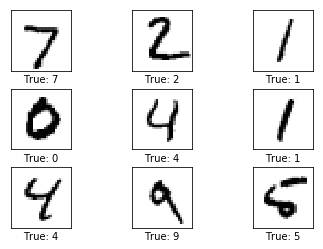

In [16]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow图

TensorFlow的全部目的就是使用一个称之为计算图（computational graph）的东西，它会比直接在Python中进行相同计算量要高效得多。TensorFlow比Numpy更高效，因为TensorFlow了解整个需要运行的计算图，然而Numpy只知道某个时间点上唯一的数学运算。

TensorFlow也能够自动地计算需要优化的变量的梯度，使得模型有更好的表现。这是由于图是简单数学表达式的结合，因此整个图的梯度可以用链式法则推导出来。

TensorFlow还能利用多核CPU和GPU，Google也为TensorFlow制造了称为TPUs（Tensor Processing Units）的特殊芯片，它比GPU更快。

一个TensorFlow图由下面几个部分组成，后面会详细描述：

* 占位符变量（Placeholder）用来改变图的输入。
* 模型变量（Model）将会被优化，使得模型表现得更好。
* 模型本质上就是一些数学函数，它根据Placeholder和模型的输入变量来计算一些输出。
* 一个cost度量用来指导变量的优化。
* 一个优化策略会更新模型的变量。

另外，TensorFlow图也包含了一些调试状态，比如用TensorBoard打印log数据，本教程不涉及这些。

### 占位符 （Placeholder）变量

Placeholder是作为图的输入，我们每次运行图的时候都可能改变它们。将这个过程称为feeding placeholder变量，后面将会描述这个。

首先我们为输入图像定义placeholder变量。这让我们可以改变输入到TensorFlow图中的图像。这也是一个张量（tensor），代表一个多维向量或矩阵。数据类型设置为float32，形状设为`[None, img_size_flat]`，`None`代表tensor可能保存着任意数量的图像，每张图象是一个长度为`img_size_flat`的向量。

In [17]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

卷积层希望`x`被编码为4维张量，因此我们需要将它的形状转换至`[num_images, img_height, img_width, num_channels]`。注意`img_height == img_width == img_size`，如果第一维的大小设为-1， `num_images`的大小也会被自动推导出来。转换运算如下：

In [18]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

接下来我们为输入变量`x`中的图像所对应的真实标签定义placeholder变量。变量的形状是`[None, num_classes]`，这代表着它保存了任意数量的标签，每个标签是长度为`num_classes`的向量，本例中长度为10。

In [19]:
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

我们也可以为class-number提供一个placeholder，但这里用argmax来计算它。这里只是TensorFlow中的一些操作，没有执行什么运算。

In [21]:
y_true_cls = tf.argmax(y_true, axis=1)

### 神经网络

这一节用PrettyTensor实现卷积神经网络，这要比直接在TensorFlow中实现来得简单，详见教程 #03。

基本思想就是用一个Pretty Tensor object封装输入张量`x_image`，它有一个添加新卷积层的帮助函数，以此来创建整个神经网络。Pretty Tensor负责变量分配等等。

In [22]:
x_pretty = pt.wrap(x_image)

现在我们已经将输入图像装到一个PrettyTensor的object中，再用几行代码就可以添加卷积层和全连接层。

注意，在`with`代码块中，`pt.defaults_scope(activation_fn=tf.nn.relu)` 把 `activation_fn=tf.nn.relu`当作每个的层参数，因此这些层都用到了 Rectified Linear Units (ReLU) 。`defaults_scope`使我们能更方便地修改所有层的参数。

In [23]:
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        conv2d(kernel=5, depth=16, name='layer_conv1').\
        max_pool(kernel=2, stride=2).\
        conv2d(kernel=5, depth=36, name='layer_conv2').\
        max_pool(kernel=2, stride=2).\
        flatten().\
        fully_connected(size=128, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



### 优化方法

PrettyTensor给我们提供了预测类型标签(`y_pred`)以及一个需要最小化的损失度量，用来提升神经网络分类图片的能力。

PrettyTensor的文档并没有说明它的损失度量是用cross-entropy还是其他的。但现在我们用`AdamOptimizer`来最小化损失。

优化过程并不是在这里执行。实际上，还没计算任何东西，我们只是往TensorFlow图中添加了优化器，以便后续操作。

In [24]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

### 性能度量

我们需要另外一些性能度量，来向用户展示这个过程。

首先我们从神经网络输出的`y_pred`中计算出预测的类别，它是一个包含10个元素的向量。类别数字是最大元素的索引。

In [25]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

然后创建一个布尔向量，用来告诉我们每张图片的真实类别是否与预测类别相同。

In [26]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

上面的计算先将布尔值向量类型转换成浮点型向量，这样子False就变成0，True变成1，然后计算这些值的平均数，以此来计算分类的准确度。

In [27]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Saver

为了保存神经网络的变量，我们创建一个称为Saver-object的对象，它用来保存及恢复TensorFlow图的所有变量。在这里并未保存什么东西，（保存操作）在后面的`optimize()`函数中完成。

注意，如果在ensemble中有超过100个的神经网络，你需要根据情况来增加`max_to_keep`。

In [28]:
saver = tf.train.Saver(max_to_keep=100)

这是用来保存或恢复数据的文件夹。

In [29]:
save_dir = 'checkpoints/'

如果文件夹不存在则创建。

In [30]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

这个函数根据输入的网络编号返回数据文件的保存路径。

In [31]:
def get_save_path(net_number):
    return save_dir + 'network' + str(net_number)

## 运行TensorFlow

### 创建TensorFlow会话（session）

一旦创建了TensorFlow图，我们需要创建一个TensorFlow会话，用来运行图。

In [32]:
session = tf.Session()

### 初始化变量

变量`weights`和`biases`在优化之前需要先进行初始化。我们写一个简单的封装函数，后面会再次调用。

In [33]:
def init_variables():
    session.run(tf.initialize_all_variables())

### 创建随机训练batch的帮助函数

在训练集中有上千张图。用这些图像计算模型的梯度会花很多时间。因此，它在优化器的每次迭代里只用到了一小部分的图像。

如果内存耗尽导致电脑死机或变得很慢，你应该试着减少这些数量，但同时可能还需要更优化的迭代。

In [39]:
train_batch_size = 64

函数根据给定的大小挑选一个随机的training-batch。

In [34]:
def random_batch(x_train, y_train):
    # Total number of images in the training-set.
    num_images = len(x_train)

    # Create a random index into the training-set.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = x_train[idx, :]  # Images.
    y_batch = y_train[idx, :]  # Labels.

    # Return the batch.
    return x_batch, y_batch

### 执行优化迭代的帮助函数

函数用来执行一定数量的优化迭代，以此来逐渐改善网络层的变量。在每次迭代中，会从训练集中选择新的一批数据，然后TensorFlow在这些训练样本上执行优化。每100次迭代会打印出（信息）。

In [35]:
def optimize(num_iterations, x_train, y_train):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch(x_train, y_train)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations and after last iteration.
        if i % 100 == 0:

            # Calculate the accuracy on the training-batch.
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            
            # Status-message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Batch Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### 创建神经网络的集成（ensemble）

神经网络ensemble的数量

In [36]:
num_networks = 5

每个神经网络优化迭代的次数。

In [37]:
num_iterations = 10000

创建神经网络的ensemble。所有网络都使用上面定义的那个TensorFlow图。每个网络的TensorFlow权重和变量都用随机值初始化，然后进行优化。接着将变量保存到磁盘中以便之后重载使用。

如果你只是想重新运行Notebook来对结果进行不同的分析，可以跳过这一步。

In [40]:
if True:
    # For each of the neural networks.
    for i in range(num_networks):
        print("Neural network: {0}".format(i))

        # Create a random training-set. Ignore the validation-set.
        x_train, y_train, _, _ = random_training_set()

        # Initialize the variables of the TensorFlow graph.
        session.run(tf.global_variables_initializer())

        # Optimize the variables using this training-set.
        optimize(num_iterations=num_iterations,
                 x_train=x_train,
                 y_train=y_train)

        # Save the optimized variables to disk.
        saver.save(sess=session, save_path=get_save_path(i))

        # Print newline.
        print()

Neural network: 0
Optimization Iteration:      1, Training Batch Accuracy:  15.6%
Optimization Iteration:    101, Training Batch Accuracy:  95.3%
Optimization Iteration:    201, Training Batch Accuracy:  90.6%
Optimization Iteration:    301, Training Batch Accuracy:  95.3%
Optimization Iteration:    401, Training Batch Accuracy:  93.8%
Optimization Iteration:    501, Training Batch Accuracy:  96.9%
Optimization Iteration:    601, Training Batch Accuracy:  92.2%
Optimization Iteration:    701, Training Batch Accuracy:  98.4%
Optimization Iteration:    801, Training Batch Accuracy:  98.4%
Optimization Iteration:    901, Training Batch Accuracy:  95.3%
Optimization Iteration:   1001, Training Batch Accuracy:  95.3%
Optimization Iteration:   1101, Training Batch Accuracy: 100.0%
Optimization Iteration:   1201, Training Batch Accuracy:  95.3%
Optimization Iteration:   1301, Training Batch Accuracy:  95.3%
Optimization Iteration:   1401, Training Batch Accuracy: 100.0%
Optimization Iteration

Optimization Iteration:   2801, Training Batch Accuracy:  98.4%
Optimization Iteration:   2901, Training Batch Accuracy:  96.9%
Optimization Iteration:   3001, Training Batch Accuracy: 100.0%
Optimization Iteration:   3101, Training Batch Accuracy:  98.4%
Optimization Iteration:   3201, Training Batch Accuracy:  96.9%
Optimization Iteration:   3301, Training Batch Accuracy:  98.4%
Optimization Iteration:   3401, Training Batch Accuracy: 100.0%
Optimization Iteration:   3501, Training Batch Accuracy: 100.0%
Optimization Iteration:   3601, Training Batch Accuracy: 100.0%
Optimization Iteration:   3701, Training Batch Accuracy:  98.4%
Optimization Iteration:   3801, Training Batch Accuracy: 100.0%
Optimization Iteration:   3901, Training Batch Accuracy:  98.4%
Optimization Iteration:   4001, Training Batch Accuracy: 100.0%
Optimization Iteration:   4101, Training Batch Accuracy: 100.0%
Optimization Iteration:   4201, Training Batch Accuracy:  98.4%
Optimization Iteration:   4301, Training

Optimization Iteration:   5601, Training Batch Accuracy:  93.8%
Optimization Iteration:   5701, Training Batch Accuracy: 100.0%
Optimization Iteration:   5801, Training Batch Accuracy:  98.4%
Optimization Iteration:   5901, Training Batch Accuracy: 100.0%
Optimization Iteration:   6001, Training Batch Accuracy:  95.3%
Optimization Iteration:   6101, Training Batch Accuracy:  96.9%
Optimization Iteration:   6201, Training Batch Accuracy:  98.4%
Optimization Iteration:   6301, Training Batch Accuracy:  98.4%
Optimization Iteration:   6401, Training Batch Accuracy: 100.0%
Optimization Iteration:   6501, Training Batch Accuracy: 100.0%
Optimization Iteration:   6601, Training Batch Accuracy:  98.4%
Optimization Iteration:   6701, Training Batch Accuracy: 100.0%
Optimization Iteration:   6801, Training Batch Accuracy:  98.4%
Optimization Iteration:   6901, Training Batch Accuracy:  98.4%
Optimization Iteration:   7001, Training Batch Accuracy:  98.4%
Optimization Iteration:   7101, Training

Optimization Iteration:   8401, Training Batch Accuracy: 100.0%
Optimization Iteration:   8501, Training Batch Accuracy: 100.0%
Optimization Iteration:   8601, Training Batch Accuracy: 100.0%
Optimization Iteration:   8701, Training Batch Accuracy: 100.0%
Optimization Iteration:   8801, Training Batch Accuracy: 100.0%
Optimization Iteration:   8901, Training Batch Accuracy: 100.0%
Optimization Iteration:   9001, Training Batch Accuracy:  98.4%
Optimization Iteration:   9101, Training Batch Accuracy: 100.0%
Optimization Iteration:   9201, Training Batch Accuracy: 100.0%
Optimization Iteration:   9301, Training Batch Accuracy:  96.9%
Optimization Iteration:   9401, Training Batch Accuracy:  98.4%
Optimization Iteration:   9501, Training Batch Accuracy: 100.0%
Optimization Iteration:   9601, Training Batch Accuracy:  98.4%
Optimization Iteration:   9701, Training Batch Accuracy: 100.0%
Optimization Iteration:   9801, Training Batch Accuracy: 100.0%
Optimization Iteration:   9901, Training

### 计算并且预测分类的帮助函数

这个函数计算了图像的预测标签，对每张图像来说，函数计算了一个长度为10的向量，向量显示了图像的类别。

计算分批完成，否则将占用太多内存。如果电脑死机了，你需要降低batch-size。

In [41]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_labels(images):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted labels which
    # will be calculated in batches and filled into this array.
    pred_labels = np.zeros(shape=(num_images, num_classes),
                           dtype=np.float)

    # Now calculate the predicted labels for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images between index i and j.
        feed_dict = {x: images[i:j, :]}

        # Calculate the predicted labels using TensorFlow.
        pred_labels[i:j] = session.run(y_pred, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    return pred_labels

计算一个布尔值向量，代表图像的预测类型是否正确。

In [42]:
def correct_prediction(images, labels, cls_true):
    # Calculate the predicted labels.
    pred_labels = predict_labels(images=images)

    # Calculate the predicted class-number for each image.
    cls_pred = np.argmax(pred_labels, axis=1)

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct

计算一个布尔数组，代表测试集中图像是否分类正确。

In [43]:
def test_correct():
    return correct_prediction(images = data.test.images,
                              labels = data.test.labels,
                              cls_true = data.test.cls)

计算一个布尔数组，代表验证集中图像是否分类正确。

In [44]:
def validation_correct():
    return correct_prediction(images = data.validation.images,
                              labels = data.validation.labels,
                              cls_true = data.validation.cls)

### 计算分类准确率的帮助函数

这个函数计算了给定布尔数组的分类准确率，布尔数组表示每张图像是否被正确分类。比如， `cls_accuracy([True, True, False, False, False]) = 2/5 = 0.4`。

In [45]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.
    return correct.mean()

计算测试集的分类准确率。

In [46]:
def test_accuracy():
    # Get the array of booleans whether the classifications are correct
    # for the test-set.
    correct = test_correct()
    
    # Calculate the classification accuracy and return it.
    return classification_accuracy(correct)

计算原始验证集上的分类准确率。

In [47]:
def validation_accuracy():
    # Get the array of booleans whether the classifications are correct
    # for the validation-set.
    correct = validation_correct()
    
    # Calculate the classification accuracy and return it.
    return classification_accuracy(correct)

## 结果与分析

函数用来为ensemble中的所有神经网络计算预测标签。后面会将这些标签合并起来。

In [48]:
def ensemble_predictions():
    # Empty list of predicted labels for each of the neural networks.
    pred_labels = []

    # Classification accuracy on the test-set for each network.
    test_accuracies = []

    # Classification accuracy on the validation-set for each network.
    val_accuracies = []

    # For each neural network in the ensemble.
    for i in range(num_networks):
        # Reload the variables into the TensorFlow graph.
        saver.restore(sess=session, save_path=get_save_path(i))

        # Calculate the classification accuracy on the test-set.
        test_acc = test_accuracy()

        # Append the classification accuracy to the list.
        test_accuracies.append(test_acc)

        # Calculate the classification accuracy on the validation-set.
        val_acc = validation_accuracy()

        # Append the classification accuracy to the list.
        val_accuracies.append(val_acc)

        # Print status message.
        msg = "Network: {0}, Accuracy on Validation-Set: {1:.4f}, Test-Set: {2:.4f}"
        print(msg.format(i, val_acc, test_acc))

        # Calculate the predicted labels for the images in the test-set.
        # This is already calculated in test_accuracy() above but
        # it is re-calculated here to keep the code a bit simpler.
        pred = predict_labels(images=data.test.images)

        # Append the predicted labels to the list.
        pred_labels.append(pred)
    
    return np.array(pred_labels), \
           np.array(test_accuracies), \
           np.array(val_accuracies)

In [49]:
pred_labels, test_accuracies, val_accuracies = ensemble_predictions()

INFO:tensorflow:Restoring parameters from checkpoints/network0
Network: 0, Accuracy on Validation-Set: 0.9948, Test-Set: 0.9898
INFO:tensorflow:Restoring parameters from checkpoints/network1
Network: 1, Accuracy on Validation-Set: 0.9938, Test-Set: 0.9895
INFO:tensorflow:Restoring parameters from checkpoints/network2
Network: 2, Accuracy on Validation-Set: 0.9940, Test-Set: 0.9883
INFO:tensorflow:Restoring parameters from checkpoints/network3
Network: 3, Accuracy on Validation-Set: 0.9928, Test-Set: 0.9862
INFO:tensorflow:Restoring parameters from checkpoints/network4
Network: 4, Accuracy on Validation-Set: 0.9922, Test-Set: 0.9854


总结ensemble中的神经网络在测试集上的分类准确率。

In [50]:
print("Mean test-set accuracy: {0:.4f}".format(np.mean(test_accuracies)))
print("Min test-set accuracy:  {0:.4f}".format(np.min(test_accuracies)))
print("Max test-set accuracy:  {0:.4f}".format(np.max(test_accuracies)))

Mean test-set accuracy: 0.9878
Min test-set accuracy:  0.9854
Max test-set accuracy:  0.9898


ensemble的预测标签是3维的数组，第一维是神经网络数量，第二维是图像数量，第三维是分类向量。

In [51]:
pred_labels.shape

(5, 10000, 10)

### ensemble预测

有几种不同的方法来计算ensemble的预测标签。一种是计算每个神经网络的预测类别数字，然后选择得票最多的那个类别。但根据分类的类别数量，这种方法需要大量的神经网络。

这里用的方法是取ensemble中所有预测标签的平均。这个计算很简单，而且集成种不需要大量的神经网络。

In [52]:
ensemble_pred_labels = np.mean(pred_labels, axis=0)
ensemble_pred_labels.shape

(10000, 10)

取标签中最大数字的索引作为ensemble的预测类别数字，这通常用argmax来计算。

In [53]:
ensemble_cls_pred = np.argmax(ensemble_pred_labels, axis=1)
ensemble_cls_pred.shape

(10000,)

布尔数组表示测试集中的图像是否被神经网络的ensemble正确分类。

In [54]:
ensemble_correct = (ensemble_cls_pred == data.test.cls)

对布尔数组取反，因此我们可以用它来查找误分类的图像。

In [55]:
ensemble_incorrect = np.logical_not(ensemble_correct)

### 最佳的神经网络

现在我们找出在测试集上表现最佳的单个神经网络。

首先列出ensemble中所有神经网络在测试集上的分类准确率。

In [56]:
test_accuracies

array([ 0.9898,  0.9895,  0.9883,  0.9862,  0.9854])

准确率最高的神经网络索引。

In [57]:
best_net = np.argmax(test_accuracies)
best_net

0

最佳神经网络在测试集上的分类准确率。

In [58]:
test_accuracies[best_net]

0.98980000000000001

最佳神经网络的预测标签。

In [59]:
best_net_pred_labels = pred_labels[best_net, :, :]

预测的类别数字。

In [60]:
best_net_cls_pred = np.argmax(best_net_pred_labels, axis=1)

最佳神经网络在测试集上是否正确分类图像的布尔数组。

In [61]:
best_net_correct = (best_net_cls_pred == data.test.cls)

图像是否被误分类的布尔数组。

In [65]:
best_net_incorrect = np.logical_not(best_net_correct)

### ensemble与最佳网络的比较

测试集中被ensemble正确分类的图像数量。

In [62]:
np.sum(ensemble_correct)

9911

测试集中被最佳网络正确分类的图像数量。

In [63]:
np.sum(best_net_correct)

9898

布尔数组表示测试集中每张图像是否“被ensemble正确分类且被最佳网络误分类”。

In [66]:
ensemble_better = np.logical_and(best_net_incorrect,
                                 ensemble_correct)

测试集上ensemble比最佳网络表现更好的图像数量：

In [67]:
ensemble_better.sum()

31

布尔数组表示测试集中每张图像是否“被最佳网络正确分类且被ensemble误分类”。

In [68]:
best_net_better = np.logical_and(best_net_correct,
                                 ensemble_incorrect)

测试集上最佳网络比ensemble表现更好的图像数量：

In [69]:
best_net_better.sum()

18

### 绘制以及打印对比的帮助函数

函数用来绘制测试集中的图像，以及它们的真实类别与预测类别。

In [70]:
def plot_images_comparison(idx):
    plot_images(images=data.test.images[idx, :],
                cls_true=data.test.cls[idx],
                ensemble_cls_pred=ensemble_cls_pred[idx],
                best_cls_pred=best_net_cls_pred[idx])

打印预测标签的函数。

In [71]:
def print_labels(labels, idx, num=1):
    # Select the relevant labels based on idx.
    labels = labels[idx, :]

    # Select the first num labels.
    labels = labels[0:num, :]
    
    # Round numbers to 2 decimal points so they are easier to read.
    labels_rounded = np.round(labels, 2)

    # Print the rounded labels.
    print(labels_rounded)

Function for printing the predicted labels for the ensemble of neural networks.

打印神经网络ensemble预测标签的函数。

In [72]:
def print_labels_ensemble(idx, **kwargs):
    print_labels(labels=ensemble_pred_labels, idx=idx, **kwargs)

打印单个网络预测标签的函数。

In [73]:
def print_labels_best_net(idx, **kwargs):
    print_labels(labels=best_net_pred_labels, idx=idx, **kwargs)

打印ensemble中所有神经网络预测标签的函数。只打印第一张图像的标签。

In [74]:
def print_labels_all_nets(idx):
    for i in range(num_networks):
        print_labels(labels=pred_labels[i, :, :], idx=idx, num=1)

## 样本：ensemble比最佳网络好

绘制出那些被集成网络正确分类，且被最佳网络误分类的样本。

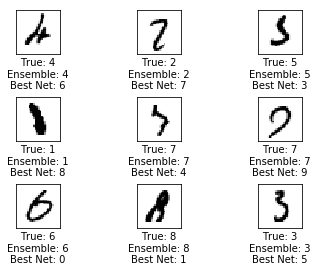

In [75]:
plot_images_comparison(idx=ensemble_better)

ensemble对第一张图像（左上）的预测标签：

In [76]:
print_labels_ensemble(idx=ensemble_better, num=1)

[[ 0.    0.    0.32  0.    0.51  0.    0.16  0.    0.    0.  ]]


最佳网络对第一张图像的预测标签：

In [77]:
print_labels_best_net(idx=ensemble_better, num=1)

[[ 0.    0.    0.07  0.    0.38  0.    0.54  0.    0.    0.  ]]


ensemble中所有网络对第一张图像的预测标签：

In [78]:
print_labels_all_nets(idx=ensemble_better)

[[ 0.    0.    0.07  0.    0.38  0.    0.54  0.    0.    0.  ]]
[[ 0.    0.    0.25  0.    0.7   0.    0.05  0.    0.    0.  ]]
[[ 0.    0.01  0.03  0.    0.95  0.    0.01  0.    0.    0.  ]]
[[ 0.    0.    0.63  0.    0.27  0.    0.1   0.    0.    0.  ]]
[[ 0.    0.    0.62  0.    0.26  0.    0.1   0.    0.02  0.  ]]


## 样本：最佳网络比ensemble好

现在绘制那些被ensemble误分类，但被最佳网络正确分类的样本。

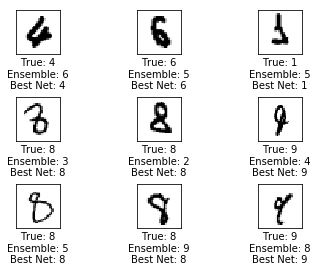

In [79]:
plot_images_comparison(idx=best_net_better)

ensemble对第一张图像（左上）的预测标签：

In [80]:
print_labels_ensemble(idx=best_net_better, num=1)

[[ 0.    0.    0.    0.    0.17  0.    0.83  0.    0.    0.  ]]


最佳网络对第一张图像的预测标签：

In [81]:
print_labels_best_net(idx=best_net_better, num=1)

[[ 0.    0.    0.    0.    0.61  0.    0.39  0.    0.    0.  ]]


ensemble中所有网络对第一张图像的预测标签：

In [82]:
print_labels_all_nets(idx=best_net_better)

[[ 0.    0.    0.    0.    0.61  0.    0.39  0.    0.    0.  ]]
[[ 0.    0.    0.    0.    0.14  0.    0.86  0.    0.    0.  ]]
[[ 0.    0.    0.    0.    0.02  0.    0.98  0.    0.    0.  ]]
[[ 0.    0.    0.    0.    0.03  0.    0.97  0.    0.    0.  ]]
[[ 0.    0.    0.    0.    0.04  0.    0.95  0.    0.    0.  ]]


## 关闭TensorFlow会话

现在我们已经用TensorFlow完成了任务，关闭session，释放资源。

In [80]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

## 总结

这篇教程创建了5个神经网络的集成（ensemble），用来识别MINIST数据集中的手写数字。ensemble取5个单独神经网络的平均值。最终稍微提高了在测试集上的分类准确率，相比单个最佳网络98.9%的准确率，ensemble是99.1%。

然而，ensemble的表现并不是一直都比单个网络好，有些单个网络正确分类的图像却被ensemble误分类。这表明神经网络ensemble的作用有点随机，可能无法提供一个提升性能的可靠方式（和单独神经网络性能相比）。

这里使用的集成学习的形式叫[bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating) (或 Bootstrap Aggregating)，它常用来避免过拟合，但对（本文中的）这个特定的神经网络和数据集来说不是必要的。在其他情况下集成学习可能仍然有效。

### 技术说明

本文在实现集成学习时用了TensorFlow中`Saver()`对象来保存和恢复神经网络中的变量。但这个功能其实是为其他目的设计的，使用在有多种类型神经网络的集成学习中，或者想同时载入多个神经网络时就有点笨拙了。有一个叫 [sk-flow](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/learn/python/learn) 的TensorFlow添加包有更简单的方法，但到2016年八月为止，它仍然处于开发的前期阶段。

## 练习

下面是一些可能会让你提升TensorFlow技能的一些建议练习。为了学习如何更合适地使用TensorFlow，实践经验是很重要的。

在你对这个Notebook进行修改之前，可能需要先备份一下。

* 改变程序的几个不同地方，看看它如何影响性能：
    * 在集成中使用更多神经网络。
    * 改变训练集的大小。
    * 改变优化迭代的次数，试着增加或减少。
* 向朋友解释程序如何工作。
* 你认为集成学习值得更多的研究吗，或者宁可专注于提升单个神经网络的性能？

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.